In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the re-uploaded smoothed relative frequency data
summary_df = pd.read_csv("/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/Temporal Trend Finalised/topic_summary_with_slope_and_volume.csv")
summary_df.head(10)

,topic,slope,total_papers,z_total_papers
0,0,-0.007693,1487,2.945410
1,1,-0.000819,920,1.479847
2,2,0.006276,808,1.190353
3,3,0.000457,762,1.071454
4,4,-0.000025,570,0.575179
5,5,-0.001751,455,0.277930
6,6,0.001732,308,-0.102030
7,7,-0.003489,299,-0.125293
8,8,0.001496,220,-0.329490
9,9,0.000384,201,-0.378600


In [6]:
# Standardize slope and total_papers for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(summary_df[["slope", "total_papers"]])

In [8]:
# Apply KMeans clustering (choose 4 clusters to mirror the quadrant logic)
kmeans = KMeans(n_clusters=4, random_state=42)
summary_df["cluster"] = kmeans.fit_predict(features_scaled)

In [18]:
# Create a summary table showing topic numbers grouped by cluster
cluster_table = summary_df.groupby("cluster")["topic"].apply(list).reset_index()
cluster_table.columns = ["Cluster", "Topics"]
cluster_table

,Cluster,Topics
0,0,"[5, 7]"
1,1,"[6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]"
2,2,[0]
3,3,"[1, 2, 3, 4]"


In [82]:
# Add the cluster labels as a new column
slope_volume_clusters = summary_df["cluster"]
slope_volume_clusters.name = "slope_volume_clusters"

# Merge with original topic IDs (assuming index alignment)
export_df = pd.DataFrame(slope_volume_clusters)

# Export to CSV
export_path = "/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/Temporal Trend Finalised/slope_volume_cluster_labels.csv"
export_df.to_csv(export_path)

In [84]:
print(summary_df.columns)

Index(['topic', 'slope', 'total_papers', 'z_total_papers', 'cluster',
       'slope_volume_cluster', 'lifecycle_label'],
      dtype='object')


In [86]:
from scipy.stats import f_oneway

# Group slope and volume by the 'cluster' column
groups_slope = [group["slope"].values for _, group in summary_df.groupby("cluster")]
groups_volume = [group["total_papers"].values for _, group in summary_df.groupby("cluster")]

# Run one-way ANOVA for slope
f_slope, p_slope = f_oneway(*groups_slope)
print("ANOVA for Slope:")
print(f"F-statistic: {f_slope:.4f}, p-value: {p_slope:.4f}")
print("=> Significant difference between clusters for slope" if p_slope < 0.05 else "=> No significant difference between clusters for slope")
print()

# Run one-way ANOVA for volume (total papers)
f_volume, p_volume = f_oneway(*groups_volume)
print("ANOVA for Volume:")
print(f"F-statistic: {f_volume:.4f}, p-value: {p_volume:.4f}")
print("=> Significant difference between clusters for volume" if p_volume < 0.05 else "=> No significant difference between clusters for volume")

ANOVA for Slope:
F-statistic: 11.7169, p-value: 0.0003
=> Significant difference between clusters for slope

ANOVA for Volume:
F-statistic: 83.5827, p-value: 0.0000
=> Significant difference between clusters for volume


In [54]:
#cluster profiling

In [56]:
cluster_profiles = summary_df.groupby("cluster")[["slope", "total_papers"]].mean().reset_index()
cluster_profiles.columns = ["cluster", "avg_slope", "avg_volume"]
print(cluster_profiles)

   cluster  avg_slope   avg_volume
0        0  -0.002620   377.000000
1        1   0.000587   108.416667
2        2  -0.007693  1487.000000
3        3   0.001472   765.000000


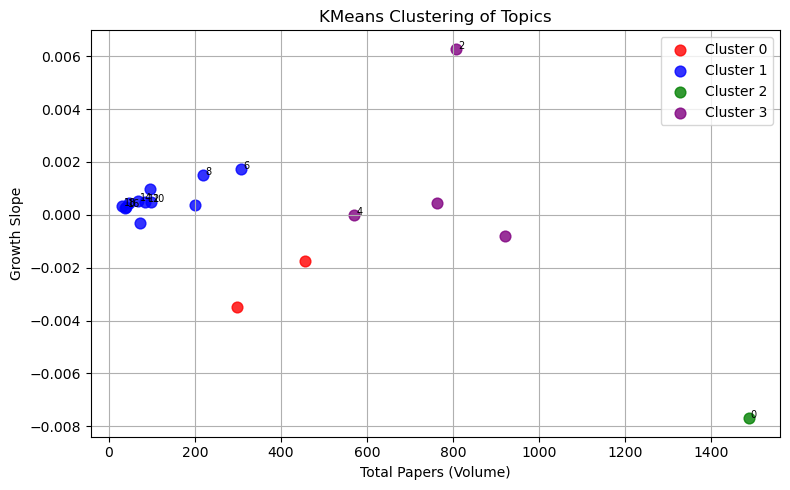

In [88]:
plt.figure(figsize=(8, 5))
colors = ["red", "blue", "green", "purple"]

# Plot each cluster
for cluster_id in sorted(summary_df["cluster"].unique()):
    cluster_data = summary_df[summary_df["cluster"] == cluster_id]
    plt.scatter(cluster_data["total_papers"], cluster_data["slope"],
                label=f"Cluster {cluster_id}", s=60, alpha=0.8, c=colors[cluster_id])

for _, row in summary_df.iterrows():
    if row["topic"] % 2 == 0: 
        plt.text(row["total_papers"] + 5, row["slope"], str(int(row["topic"])), fontsize=7)

plt.title("KMeans Clustering of Topics")
plt.xlabel("Total Papers (Volume)")
plt.ylabel("Growth Slope")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [90]:
# Example mapping — adjust based on your results
cluster_to_label = {
    0: "Saturated",
    1: "Rising Star",
    2: "Declining",
    3: "Mature Topic"
}

summary_df["lifecycle_label"] = summary_df["cluster"].map(cluster_to_label)

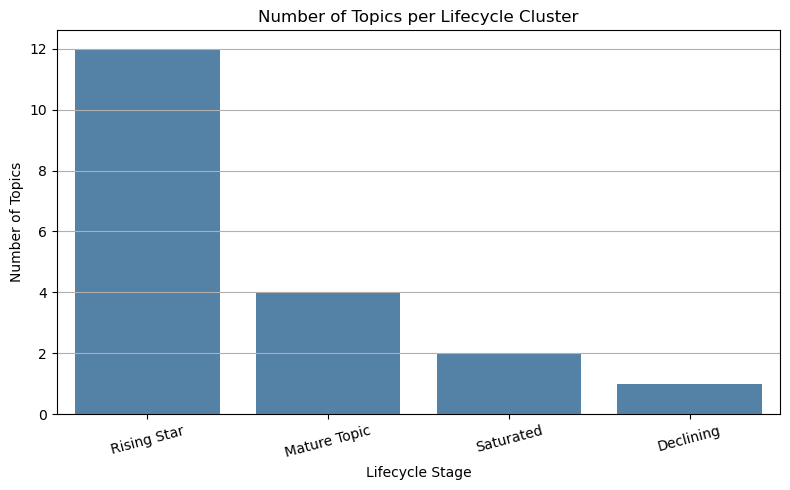

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of topics per lifecycle label
cluster_counts = summary_df["lifecycle_label"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, color="steelblue")
plt.title("Number of Topics per Lifecycle Cluster")
plt.ylabel("Number of Topics")
plt.xlabel("Lifecycle Stage")
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis="y")
plt.show()

/var/folders/zl/q3jfwlms76dfjrk9dywsgcmm0000gn/T/ipykernel_13087/3122082492.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_by_lifecycle = summary_df.groupby("lifecycle_label")["total_papers"].sum()


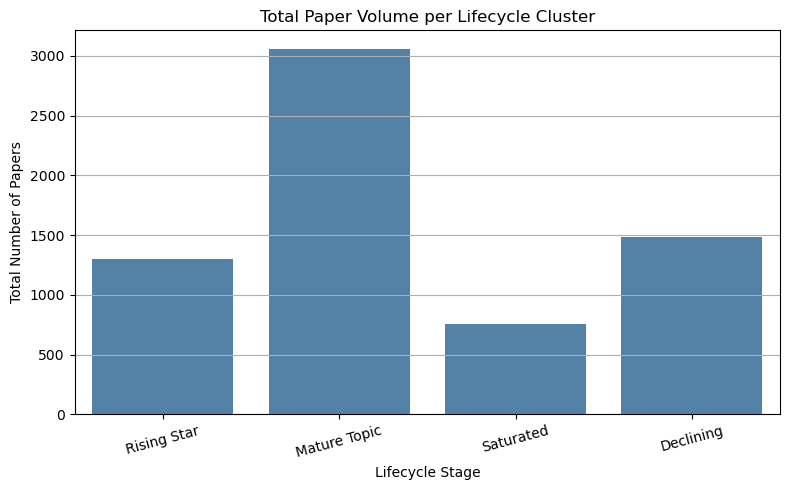

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define desired order
desired_order = ["Rising Star", "Mature Topic", "Saturated", "Declining"]

# Convert to Categorical for proper ordering
summary_df["lifecycle_label"] = pd.Categorical(summary_df["lifecycle_label"], categories=desired_order, ordered=True)

# Sum total papers per lifecycle category (now with proper order)
volume_by_lifecycle = summary_df.groupby("lifecycle_label")["total_papers"].sum()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=volume_by_lifecycle.index, y=volume_by_lifecycle.values, color="steelblue")
plt.title("Total Paper Volume per Lifecycle Cluster")
plt.ylabel("Total Number of Papers")
plt.xlabel("Lifecycle Stage")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

/var/folders/zl/q3jfwlms76dfjrk9dywsgcmm0000gn/T/ipykernel_13087/1552754265.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slope_by_lifecycle = summary_df.groupby("lifecycle_label")["slope"].mean()


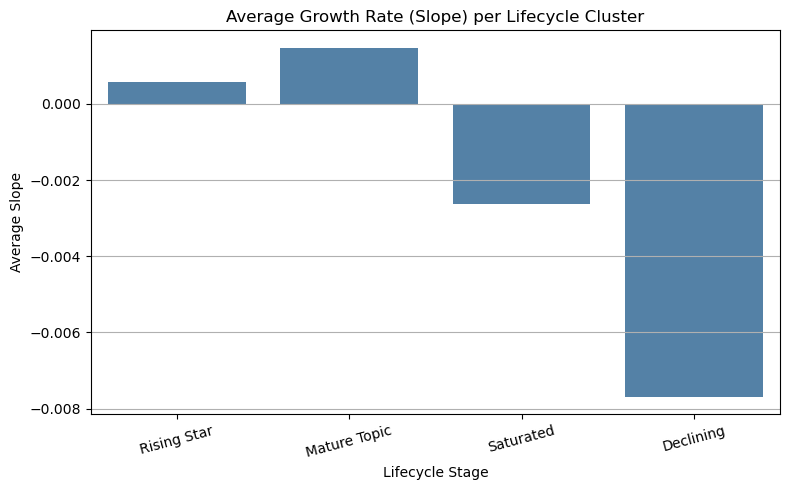

In [106]:
# Calculate average slope per lifecycle category
slope_by_lifecycle = summary_df.groupby("lifecycle_label")["slope"].mean()

# Ensure the order is correct
slope_by_lifecycle = slope_by_lifecycle.reindex(desired_order)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=slope_by_lifecycle.index, y=slope_by_lifecycle.values, color="steelblue")
plt.title("Average Growth Rate (Slope) per Lifecycle Cluster")
plt.ylabel("Average Slope")
plt.xlabel("Lifecycle Stage")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.tight_layout()
plt.show()